In [1]:
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract(
    "./Main_27.04.2023.apkg", filter_out_suspended_cards, filter_out_flags
)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False
)
optimizer.define_model()
optimizer.pretrain(verbose=False)

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.


[]

In [2]:
from torch import Tensor, nn
import torch
from statsmodels.nonparametric.smoothers_lowess import lowess


class ICILoss(nn.Module):
    def __init__(self):
        super(ICILoss, self).__init__()
        # self.loss_fn = nn.L1Loss(reduce="None")
        self.loss_fn = nn.MSELoss(reduce="None")

    def forward(self, predictions: Tensor, labels: Tensor) -> Tensor:
        observation = lowess(
            labels.detach().numpy(),
            predictions.detach().numpy(),
            it=0,
            delta=0.01
            * (max(predictions.detach().numpy()) - min(predictions.detach().numpy())),
            return_sorted=False,
        )
        observation = torch.as_tensor(observation, dtype=torch.float32)
        # return self.loss_fn(predictions, observation)
        return torch.sqrt(self.loss_fn(predictions, observation))

  0%|          | 0/247973 [00:00<?, ?it/s]

train:   0%|          | 0/3861040 [00:00<?, ?it/s]

iteration: 384675
w: [0.2721, 0.2715, 1.1176, 99.9986, 7.1916, 0.537, 1.4635, 0.001, 1.5472, 0.1229, 1.0209, 1.9383, 0.1118, 0.2947, 2.2684, 0.234, 2.9919, 0.5091, 0.6674]
iteration: 769001
w: [0.2773, 0.2752, 1.1204, 99.9982, 7.188, 0.5402, 1.4652, 0.001, 1.5492, 0.1265, 1.0232, 1.9376, 0.1131, 0.2939, 2.2674, 0.2373, 2.9948, 0.5021, 0.6727]
iteration: 1153676
w: [0.282, 0.2793, 1.1231, 99.9973, 7.1843, 0.5436, 1.4669, 0.001, 1.5515, 0.1289, 1.0257, 1.937, 0.1144, 0.2932, 2.2665, 0.2402, 2.9974, 0.4961, 0.6773]
iteration: 1538002
w: [0.2854, 0.2818, 1.1247, 99.9965, 7.1818, 0.5458, 1.469, 0.001, 1.5526, 0.1316, 1.027, 1.9361, 0.1157, 0.2922, 2.2654, 0.2418, 2.9991, 0.4907, 0.681]
iteration: 1922677
w: [0.2881, 0.2844, 1.1264, 99.996, 7.18, 0.5475, 1.4709, 0.001, 1.5534, 0.1337, 1.0279, 1.9356, 0.1167, 0.2915, 2.2647, 0.2431, 3.0004, 0.4865, 0.6839]
iteration: 2307003
w: [0.2905, 0.2863, 1.1277, 99.9957, 7.1782, 0.5492, 1.4719, 0.001, 1.5546, 0.1349, 1.0292, 1.9356, 0.117, 0.2915, 2.26

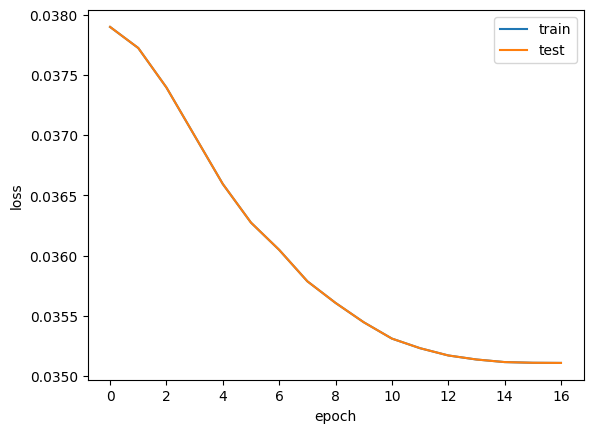

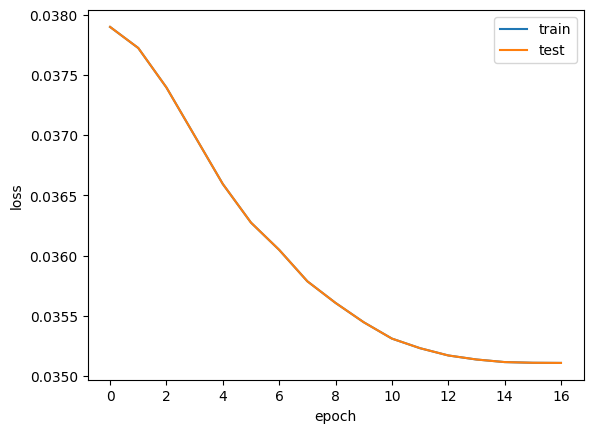

In [3]:
from fsrs_optimizer import Trainer, lineToTensor
import numpy as np

lr: float = 1e-4
n_epoch: int = 16
n_splits: int = 2
batch_size: int = 4096
verbose: bool = True

dataset = optimizer.dataset
dataset["tensor"] = dataset.progress_apply(
    lambda x: lineToTensor(list(zip([x["t_history"]], [x["r_history"]]))[0]),
    axis=1,
)
dataset["group"] = dataset["r_history"] + dataset["t_history"]

trainer = Trainer(
    dataset,
    dataset,
    optimizer.init_w,
    n_epoch=n_epoch,
    lr=lr,
    batch_size=batch_size,
)
trainer.loss_fn = ICILoss()
optimizer.w = trainer.train(verbose=verbose)
trainer.plot()

Loss before training: 0.4272
Loss after training: 0.4175
RMSE(bins): 0.0420

Last rating: 1
RMSE(bins): 0.0635

Last rating: 2
RMSE(bins): 0.0472

Last rating: 3
RMSE(bins): 0.0419

Last rating: 4
RMSE(bins): 0.0512


{'all': {'R-squared': 0.8479154769746009,
  'MAE': 0.022882292040824537,
  'ICI': 0.021954558844473615,
  'E50': 0.01524565320017246,
  'E90': 0.03570024344986378,
  'EMax': 0.3335071951037618,
  'RMSE(bins)': 0.04200476553507605,
  'AUC': 0.6844462202597422},
 1: {'R-squared': 0.3854067954355902,
  'MAE': 0.06651321218901167,
  'ICI': 0.06433537889170317,
  'E50': 0.06437141190318496,
  'E90': 0.09489662466695703,
  'EMax': 0.33023603423031256,
  'RMSE(bins)': 0.06351464189595123,
  'AUC': 0.665306571176453},
 2: {'R-squared': 0.7626919088322768,
  'MAE': 0.04019816208820556,
  'ICI': 0.03732079103044913,
  'E50': 0.03463688456951314,
  'E90': 0.041120513374906076,
  'EMax': 0.34446404544465814,
  'RMSE(bins)': 0.04721234502374258,
  'AUC': 0.6724137296768364},
 3: {'R-squared': 0.914922316386476,
  'MAE': 0.014115343422075684,
  'ICI': 0.012139655311576045,
  'E50': 0.006740660204406668,
  'E90': 0.021256006587042242,
  'EMax': 0.24609857984815434,
  'RMSE(bins)': 0.04188243279567508

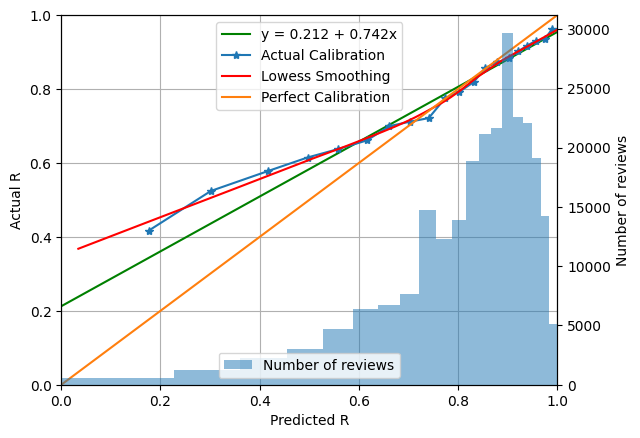

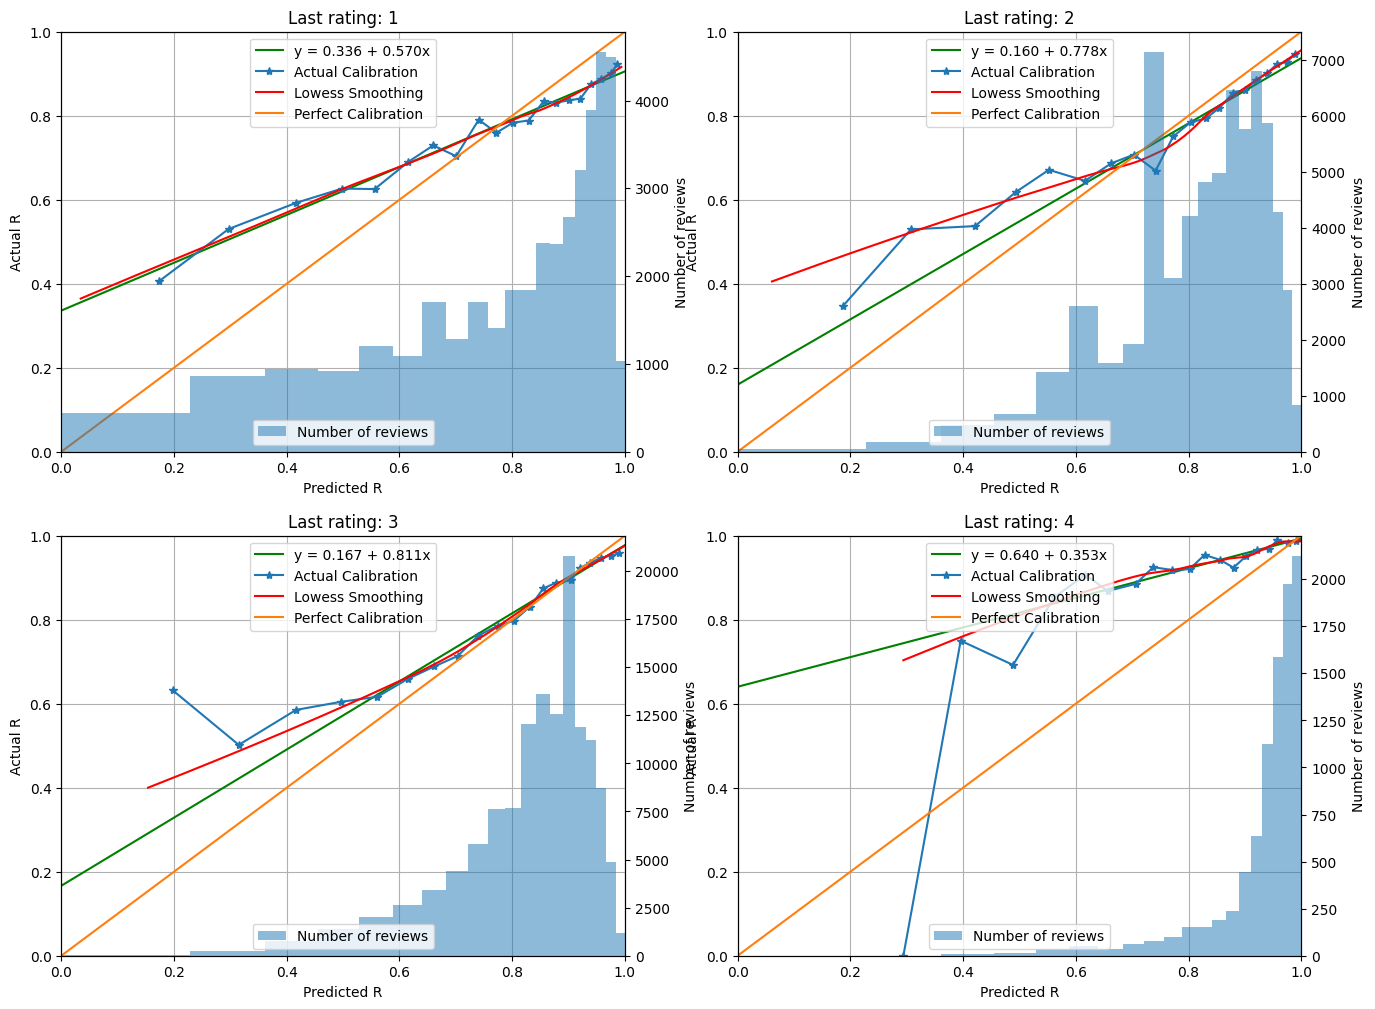

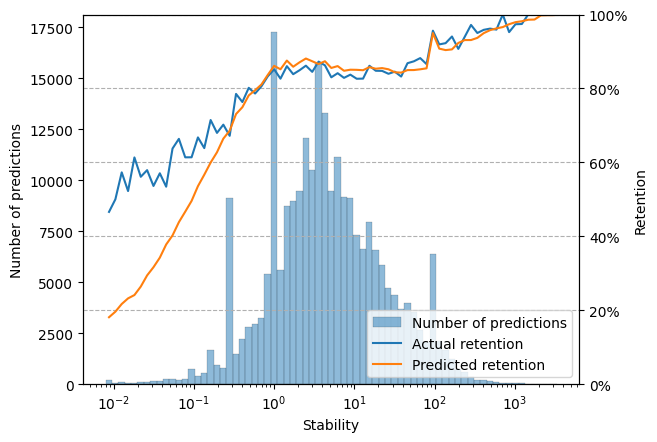

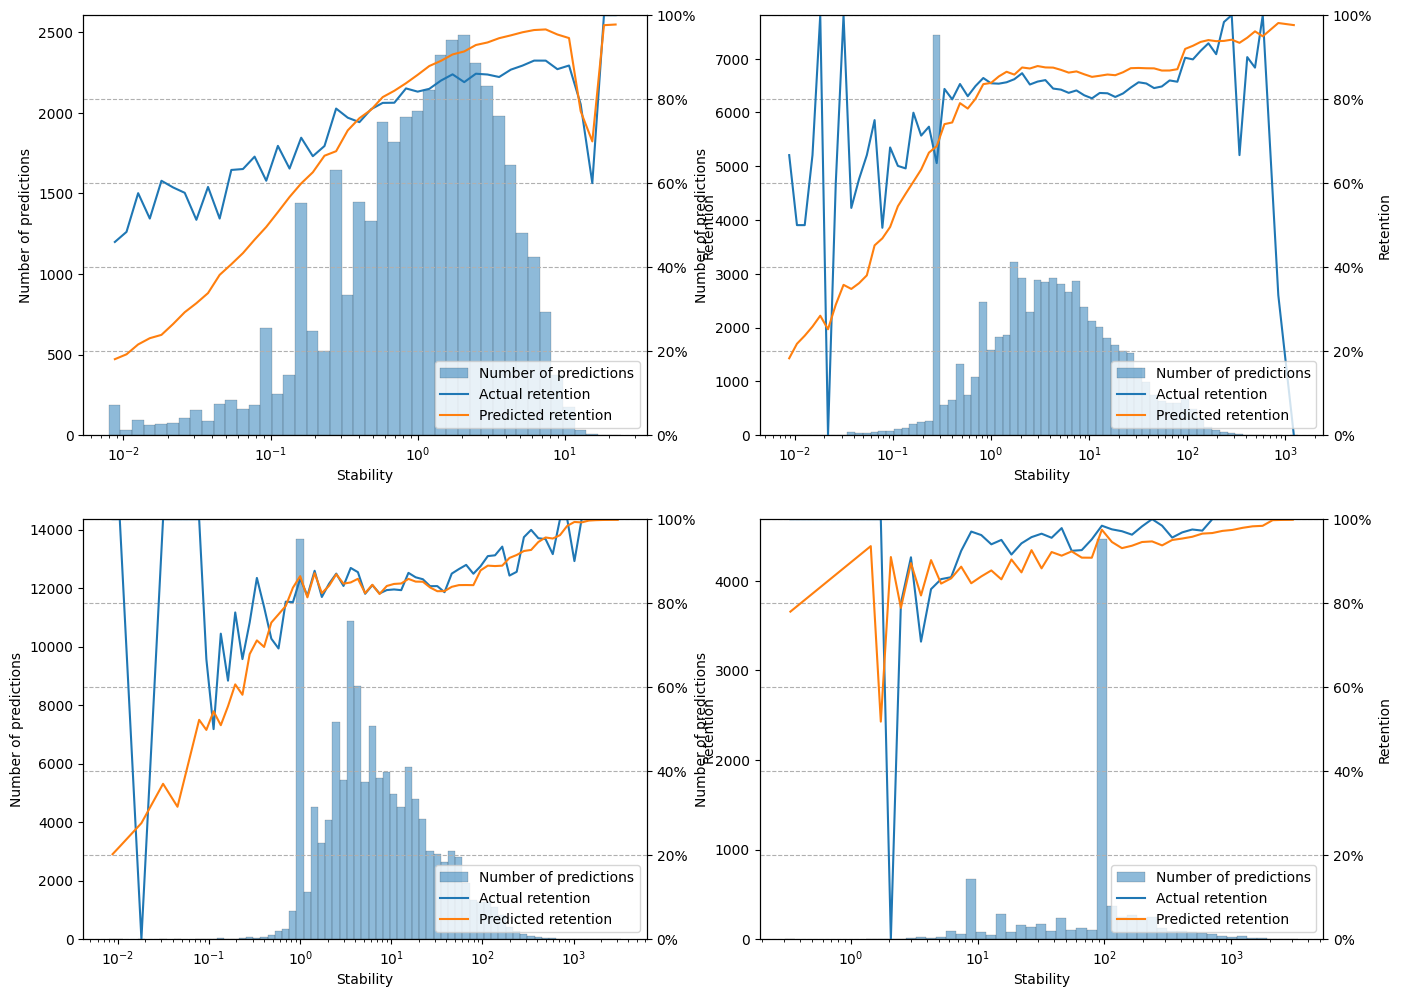

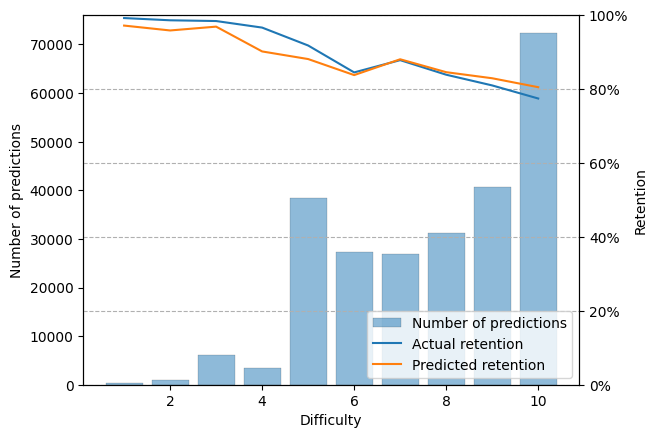

In [4]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()
metrics

train:   0%|          | 0/1206575 [00:00<?, ?it/s]

iteration: 120832
w: [0.744, 0.6248, 1.6481, 100.0, 5.6315, 0.4989, 2.4385, 0.001, 1.6054, 0.4021, 1.3878, 1.8681, 0.25, 0.2201, 2.9329, 0.2735, 4.0765, 0.1749, 0.6645]
iteration: 241664
w: [1.0037, 0.6996, 1.3161, 99.9899, 4.9244, 0.5665, 2.8307, 0.0098, 1.4513, 0.3967, 1.3357, 1.8935, 0.2135, 0.3231, 3.4026, 0.1866, 4.1217, 0.0, 0.8189]
iteration: 362147
w: [1.0872, 0.4454, 1.0361, 99.6921, 4.1075, 0.5249, 2.6969, 0.0022, 1.3159, 0.2812, 1.2944, 1.8516, 0.25, 0.3482, 3.55, 0.1623, 4.4047, 0.1586, 0.7172]
iteration: 482979
w: [1.1733, 0.5171, 1.0393, 99.5131, 3.8328, 0.5374, 2.5824, 0.0084, 1.3927, 0.2714, 1.4381, 1.7664, 0.2413, 0.2839, 3.5771, 0.1871, 4.139, 0.0396, 0.793]
iteration: 603462
w: [1.1896, 0.5972, 1.2578, 100.0, 3.5887, 0.4461, 2.5773, 0.001, 1.3676, 0.27, 1.4812, 1.7412, 0.2405, 0.2863, 3.7162, 0.155, 4.2265, 0.0441, 0.7698]
iteration: 724294
w: [1.2065, 0.5061, 1.3676, 99.9208, 3.3992, 0.6196, 2.6722, 0.0165, 1.3133, 0.2126, 1.4472, 1.767, 0.2179, 0.3151, 3.7753, 0.14

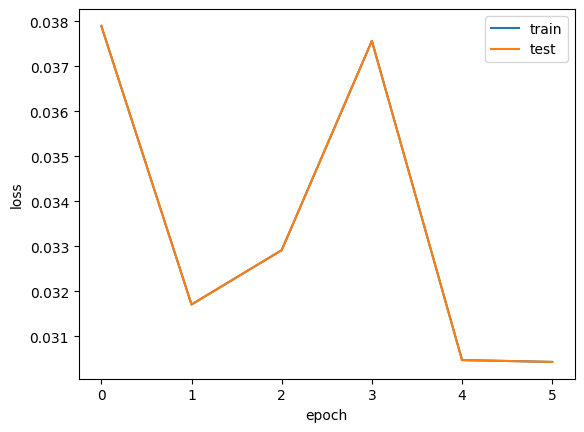

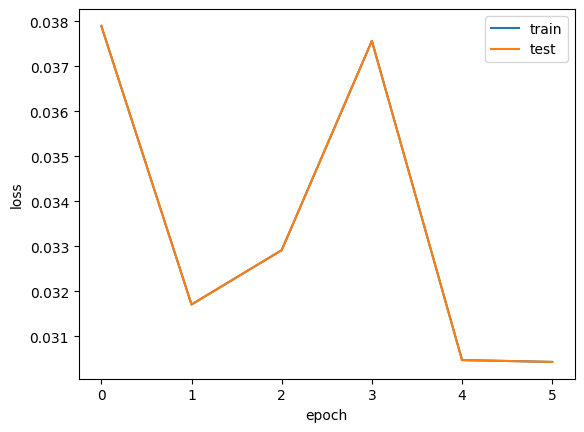

In [5]:
lr: float = 4e-2
n_epoch: int = 5
n_splits: int = 5
batch_size: int = 512
verbose: bool = True

trainer = Trainer(
    dataset,
    dataset,
    optimizer.init_w,
    n_epoch=n_epoch,
    lr=lr,
    batch_size=batch_size,
)
trainer.loss_fn = ICILoss()
optimizer.w = trainer.train(verbose=verbose)
trainer.plot()

Loss before training: 0.4272
Loss after training: 0.4177
RMSE(bins): 0.0395

Last rating: 1
RMSE(bins): 0.0545

Last rating: 2
RMSE(bins): 0.0522

Last rating: 3
RMSE(bins): 0.0375

Last rating: 4
RMSE(bins): 0.0414


{'all': {'R-squared': 0.8745143122508676,
  'MAE': 0.026161091539434685,
  'ICI': 0.025607643935575592,
  'E50': 0.023097325364737853,
  'E90': 0.036016118797028596,
  'EMax': 0.2719957151814438,
  'RMSE(bins)': 0.0394720651881624,
  'AUC': 0.6861215753155896},
 1: {'R-squared': 0.5653531639751463,
  'MAE': 0.05169757935476431,
  'ICI': 0.05107531957428338,
  'E50': 0.05482613771104794,
  'E90': 0.08808997609641885,
  'EMax': 0.1696186366116053,
  'RMSE(bins)': 0.05445703353099159,
  'AUC': 0.6447631457915557},
 2: {'R-squared': 0.6934967664120774,
  'MAE': 0.0418183171622747,
  'ICI': 0.040045769659376125,
  'E50': 0.039749806510094465,
  'E90': 0.054941994616068524,
  'EMax': 0.2662738290289404,
  'RMSE(bins)': 0.05216932330317434,
  'AUC': 0.6672368208555622},
 3: {'R-squared': 0.8949196176295919,
  'MAE': 0.016942963741281233,
  'ICI': 0.01535395751060074,
  'E50': 0.008243910454922898,
  'E90': 0.0265485209213979,
  'EMax': 0.27633023375866134,
  'RMSE(bins)': 0.03751587265217217,

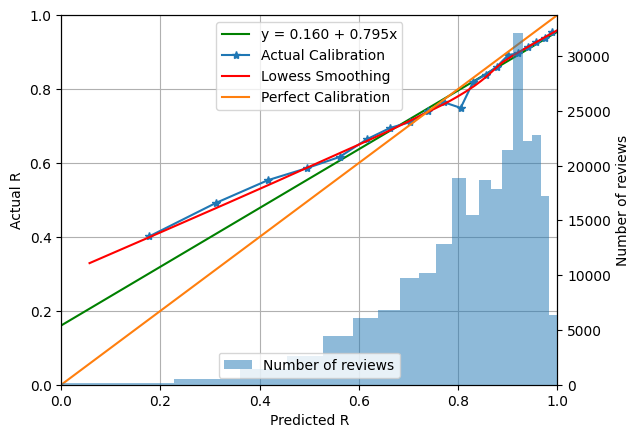

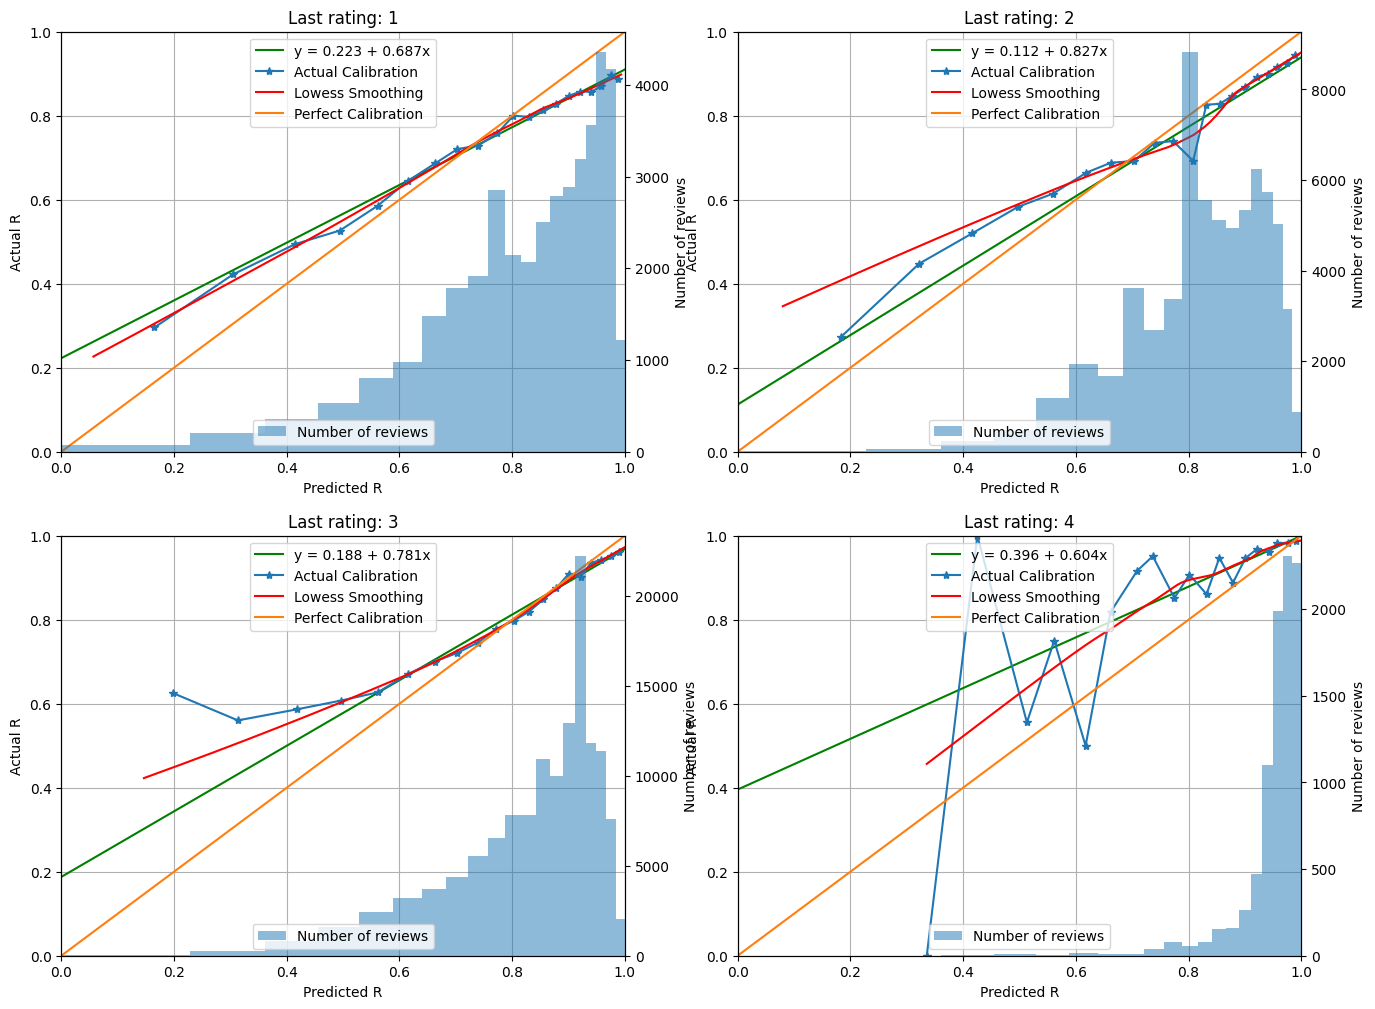

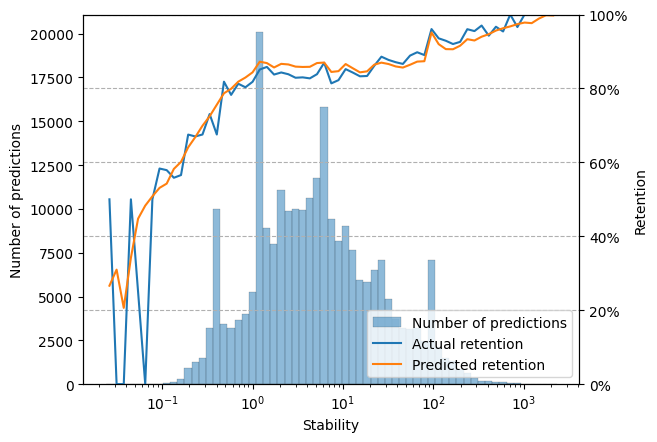

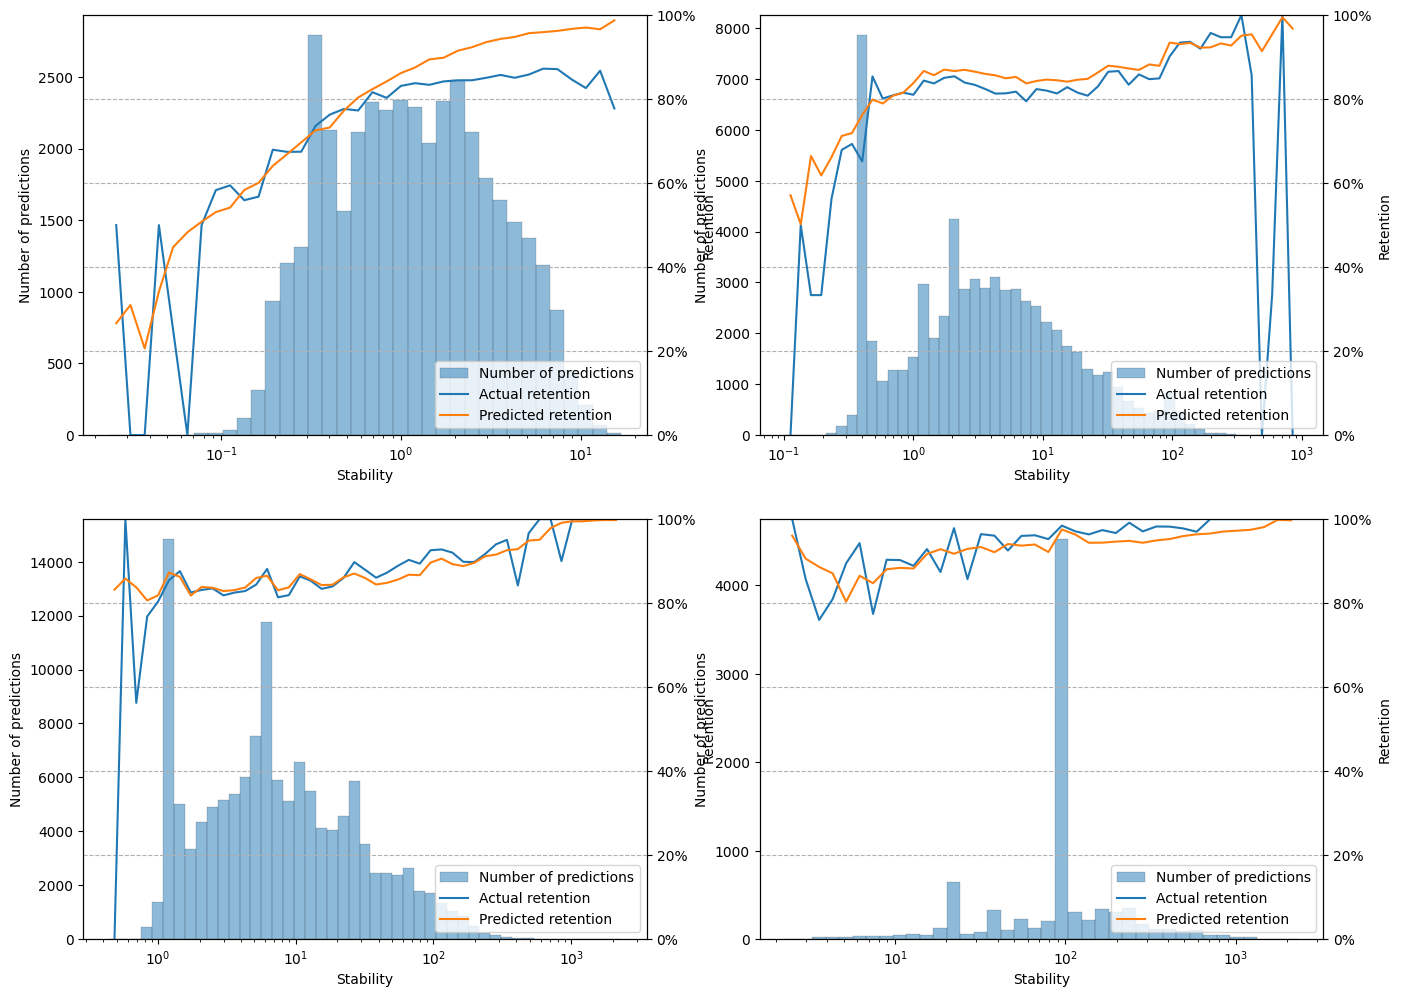

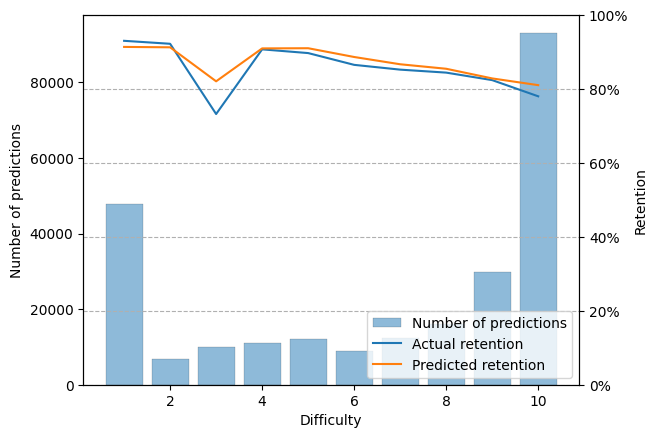

In [7]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()
metrics